In [47]:
import pandas as pd
from pprint import pprint
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score, \
confusion_matrix, roc_auc_score, SCORERS,matthews_corrcoef,roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, cross_validate
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, CategoricalNB
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC, NuSVC
from numpy import mean, std
import numpy as np
import imblearn
from collections import Counter
import shap
import lime
from lime import lime_tabular
import pickle

In [48]:
import warnings
warnings.filterwarnings('ignore')
from contextlib import suppress

# Reading the Data

In [49]:
data = pd.read_csv("final_combined_data.csv")
data = data.drop(columns=['Unnamed: 0', 'oximeter'])
data['gender']=np.where(data['gender']=='M',1,0)
data.rename(columns={'body_weakness':'body weakness',
                    'breadth':'breathlessness',
                     'clexane':'enoxaparin',
                     'kidney':'kidney disorder',
                     'heart':'heart disorder',
                     'gender':'male gender',
                     'thyroid':'thyroid disorder'},inplace=True)

In [50]:
pd.set_option('display.max_columns',100)
data.head()

tuberclosis  weakness  diarrhea  remdesivir  age  vit_d  zinc  enoxaparin  \
0            0         0         1           0   70      0     0           0   
1            0         0         0           1   65      0     0           1   
2            0         0         0           0   46      0     0           0   
3            1         0         0           0   40      0     0           0   
4            0         0         1           0   72      0     0           0   

   male gender  hypertension  on_steroids  ivermectin  headache  \
0            1             1            0           0         0   
1            1             0            0           0         0   
2            1             0            0           0         0   
3            1             0            0           0         0   
4            1             0            0           0         0   

   kidney disorder  vit_c  thyroid disorder  heart disorder outcome  \
0                0      0                 0               0   death   
1                0      0                 0               0   death   
2                0      0                 0               0   death   
3                0      0                 0               0   death   
4                0      0                 0               0   death   

   breathlessness  body weakness  diabetes  copd  cough  
0               0              0         0     0      1  
1               0              0         0     0      1  
2               0              0         0     0      0  
3               0              0         0     0      0  
4               0              0         1     0      1

# Features in Dataset

In [51]:
symptoms = ['cough','body weakness', 'breathlessness','diarrhea']
comorbidity = ['heart disorder', 'kidney disorder', 'hypertension', 'tuberclosis', 'diabetes', 'thyroid disorder', 'copd']
treatment = ['enoxaparin', 'ivermectin','remdesivir','zinc', 'vit_c','vit_d']
demographics=dem= ['age', 'male gender']


In [52]:
seed = 0 
np.random.seed(seed)

In [53]:
X = data[demographics+symptoms+comorbidity+treatment]
y = (data['outcome']=='death').astype(int)          # 1 for death, 0 for discharged
cv = StratifiedKFold(n_splits=5,random_state=seed,shuffle=True)

In [54]:
def cross_v(clf, X, y, sampling=None):
    '''This function splits X and y in 5 folds to perform cross validation. If a sampler is provided, it samples each of the individual folds and then uses these as Train, Test fold respectively'''
    
    metrics={
        
        
        "f1_score_weighted":[],
        "precision_weighted":[],
        "recall_weighted":[],
        "rocauc":[],
        "matthews_corrcoef":[],
        "accuracy_score":[],
        "sensitivity":[],
        "specificity":[],
        "ppv":[],
        "npv":[],
        
    }
    cf = np.zeros((5,2,2))

    #Choosing sampler
    sampler=None
    
    if sampling == 'oversample':
        sampler = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority',random_state=seed)
    if sampling == 'undersample':
        sampler = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority',random_state=seed)
    if sampling == 'adasyn':
        sampler = imblearn.over_sampling.ADASYN(sampling_strategy='minority',random_state=seed)
    if sampling == 'smote':
        sampler = imblearn.over_sampling.SMOTE(sampling_strategy='minority',random_state=seed)
        
    

    i=0
    for train, test in cv.split(X, y):
        X_train,X_test,y_train,y_test = X.iloc[train],X.iloc[test],y.iloc[train],y.iloc[test]
        
        if sampler != None:                                                        #Optional sampling
            X_train,y_train = sampler.fit_resample(X_train,y_train)
                
                
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

        cf[i][0][0] = TN
        cf[i][0][1] = FP
        cf[i][1][0] = FN
        cf[i][1][1] = TP
        i+=1

        metrics["f1_score_weighted"].append(f1_score(y_test, y_pred))
        metrics["precision_weighted"].append(precision_score(y_test, y_pred, average='weighted'))
        metrics["recall_weighted"].append(recall_score(y_test, y_pred, average='weighted'))
        metrics["rocauc"].append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
        metrics["matthews_corrcoef"].append(matthews_corrcoef(y_test, y_pred))
        metrics["accuracy_score"].append(accuracy_score(y_test, y_pred))

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        metrics["sensitivity"].append(TPR)

        # Specificity or true negative rate
        TNR = TN/(TN+FP)
        metrics["specificity"].append(TNR)

        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        metrics["ppv"].append(PPV)

        # Negative predictive value
        NPV = TN/(TN+FN)
        metrics["npv"].append(NPV)
        
    final = {}
    
    for met in metrics:
        final[met]={"mean":np.array(metrics[met]).mean(),
                   "std":np.array(metrics[met]).std()}
        


    return final, clf, cf

In [55]:
def _print(cc):
    metrics=['f1_score_weighted','matthews_corrcoef','accuracy_score','rocauc','ppv','npv','sensitivity','specificity']
    print_df = pd.DataFrame(index=['Mean','Std'])
    for met in metrics:
        print_df[met] = [cc[met]['mean'],cc[met]['std']]
    
    display(print_df)


## Logistic regression 

In [56]:
lr_final = LogisticRegression(solver='newton-cg', class_weight={0: 5.5, 1:0.55},random_state=seed)
cc= cross_v(lr_final, X, y)
_print(cc[0])

f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.889213           0.474699        0.818876  0.928753   
Std            0.009473           0.029299        0.013911  0.016986   

           ppv       npv  sensitivity  specificity  
Mean  0.979725  0.355744     0.814213     0.857827  
Std   0.006546  0.019662     0.016798     0.046775

## SVC

In [57]:
svm = SVC(probability=True, class_weight={0: 5.5, 1:0.55},random_state=seed)
cc= cross_v(svm, X, y)
_print(cc[0])

f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.663089           0.222715        0.543414  0.799669   
Std            0.044933           0.016526        0.043876  0.034562   

           ppv       npv  sensitivity  specificity  
Mean  0.966747  0.171543     0.506599     0.852113  
Std   0.004531  0.009934     0.052781     0.035059

## Naive Bayes

In [58]:
gnb = ComplementNB()
cc= cross_v(gnb, X, y)
_print(cc[0])

f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.896348           0.468174        0.828545  0.902777   
Std            0.004834           0.037806        0.007588  0.031929   

           ppv       npv  sensitivity  specificity  
Mean  0.974694  0.363819     0.829780     0.817948  
Std   0.008941  0.015874     0.009427     0.065896

## Random Forest

In [59]:
rf = RandomForestClassifier(n_estimators=200, class_weight={0: 5.5, 1:0.55},random_state=seed)
cc= cross_v(rf, X, y)
_print(cc[0])

f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.957604           0.556027        0.923192  0.905233   
Std            0.002409           0.038149        0.004636  0.019717   

           ppv       npv  sensitivity  specificity  
Mean  0.945025  0.679442     0.970558     0.525392  
Std   0.006083  0.016608     0.002532     0.056826

## ExtraTrees

In [60]:
et = ExtraTreesClassifier(n_estimators=100, class_weight={0: 5.5, 1:0.55},random_state=seed)
cc= cross_v(et, X, y)
_print(cc[0])

f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.950404           0.508247        0.910793  0.867232   
Std            0.003230           0.046107        0.006074  0.024827   

           ppv       npv  sensitivity  specificity  
Mean  0.944582  0.589435     0.956345     0.528209  
Std   0.006994  0.027424     0.003917     0.064161

## XGBoost

In [61]:
gb_final = GradientBoostingClassifier(n_estimators=100,random_state=seed)
cc = cross_v(gb_final, X, y)
_print(cc[0])

f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.957420           0.568410        0.923191  0.934590   
Std            0.004854           0.056555        0.008905  0.015412   

           ppv       npv  sensitivity  specificity  
Mean  0.948849  0.662814     0.966159     0.562334  
Std   0.006700  0.043513     0.003549     0.060116

## Adaboost

In [62]:
ada = AdaBoostClassifier(base_estimator=GradientBoostingClassifier(n_estimators=100,random_state=seed), n_estimators=5,random_state=seed)
cc= cross_v(ada, X, y)
_print(cc[0])

f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.956053           0.543213        0.920471  0.921582   
Std            0.002849           0.045506        0.005465  0.012333   

           ppv       npv  sensitivity  specificity  
Mean  0.944592  0.658751     0.967851     0.522575  
Std   0.007245  0.021708     0.003707     0.067892

## Adaboost **

In [63]:
ada_final = AdaBoostClassifier(n_estimators=54,random_state=seed)
cc= cross_v(ada_final, X, y)
_print(cc[0])

f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.958002           0.568490        0.924096  0.925285   
Std            0.003826           0.040455        0.006900  0.015052   

           ppv       npv  sensitivity  specificity  
Mean  0.947386  0.677943     0.968866     0.548129  
Std   0.003351  0.046896     0.005087     0.031299

# Sampling

In [64]:
classifier_names = ['Random Forest','XGBoost','Adaboost**']
samplers = ['oversample','undersample','adasyn','smote']    

classifiers=[RandomForestClassifier(n_estimators=200,random_state=seed),
            GradientBoostingClassifier(n_estimators=100,random_state=seed),
            AdaBoostClassifier(n_estimators=54)
            ]

## Random Oversampling

In [65]:
sampler = 'oversample'
for classifier,name in zip(classifiers,classifier_names):
    cc = cross_v(classifier,X,y,sampler)
    print(name)    
    _print(cc[0])


Random Forest


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.951792           0.545646        0.913818  0.903461   
Std            0.002705           0.039801        0.005074  0.017305   

           ppv       npv  sensitivity  specificity  
Mean  0.951695  0.595042     0.951946     0.593481  
Std   0.006986  0.020861     0.004615     0.063283

XGBoost


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.930213            0.55391        0.880861  0.931205   
Std            0.008512            0.02492        0.012993  0.015019   

           ppv       npv  sensitivity  specificity  
Mean  0.974597  0.468506     0.890017     0.803742  
Std   0.006905  0.030354     0.019292     0.057025

Adaboost**


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.904087           0.494883        0.840647  0.923544   
Std            0.011024           0.040483        0.016968  0.015135   

           ppv       npv  sensitivity  specificity  
Mean  0.976920  0.386954     0.841624     0.832153  
Std   0.007512  0.032156     0.019750     0.056186

## Random Undersampling

In [66]:
sampler = 'undersample'
for classifier,name in zip(classifiers,classifier_names):
    cc = cross_v(classifier,X,y,sampler)
    print(name)    
    _print(cc[0])


Random Forest


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.890432           0.476143        0.820684  0.919751   
Std            0.010319           0.015014        0.014647  0.019315   

           ppv       npv  sensitivity  specificity  
Mean  0.979449  0.358447     0.816582     0.854970  
Std   0.005564  0.018089     0.020574     0.042831

XGBoost


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.895612           0.478895        0.827941  0.920647   
Std            0.006526           0.029671        0.009719  0.018824   

           ppv       npv  sensitivity  specificity  
Mean  0.977680  0.366167     0.826396     0.840845  
Std   0.007069  0.016101     0.012369     0.051725

Adaboost**


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.886625           0.462778        0.814951  0.913134   
Std            0.013485           0.024266        0.018907  0.017853   

           ppv       npv  sensitivity  specificity  
Mean  0.977768  0.349521     0.811506     0.843461  
Std   0.007089  0.020311     0.025179     0.052995

## ADASYN Oversampling

In [67]:
sampler = 'adasyn'
for classifier,name in zip(classifiers,classifier_names):
    cc = cross_v(classifier,X,y,sampler)
    print(name)    
    _print(cc[0])


Random Forest


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.950326           0.554000        0.911702  0.904410   
Std            0.001030           0.024161        0.002086  0.019134   

           ppv       npv  sensitivity  specificity  
Mean  0.955569  0.578013     0.945178     0.630503  
Std   0.004962  0.007817     0.003799     0.045151

XGBoost


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.940777           0.556221        0.896886  0.919177   
Std            0.006105           0.057060        0.010786  0.018476   

           ppv       npv  sensitivity  specificity  
Mean  0.966526  0.510245     0.916413     0.732877  
Std   0.009306  0.034583     0.006295     0.075848

Adaboost**


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.929327           0.519163        0.878445  0.911550   
Std            0.008779           0.057498        0.014723  0.018477   

           ppv       npv  sensitivity  specificity  
Mean  0.966764  0.457126     0.894755     0.741489  
Std   0.008822  0.039763     0.011888     0.069234

## SMOTE Oversampling

In [68]:
sampler = 'smote'
for classifier,name in zip(classifiers,classifier_names):
    cc = cross_v(classifier,X,y,sampler)
    print(name)    
    _print(cc[0])

Random Forest


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.951749           0.562001        0.914118  0.901587   
Std            0.003114           0.046878        0.005966  0.017831   

           ppv       npv  sensitivity  specificity  
Mean  0.956039  0.588438     0.947547     0.633199  
Std   0.008066  0.018977     0.001854     0.071031

XGBoost


f1_score_weighted  matthews_corrcoef  accuracy_score   rocauc       ppv  \
Mean           0.950794           0.587622        0.913215  0.92209  0.963531   
Std            0.006636           0.055406        0.011646  0.01856  0.006997   

           npv  sensitivity  specificity  
Mean  0.576215     0.938409     0.701569  
Std   0.045132     0.007687     0.057869

Adaboost**


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.935410           0.534942        0.888118  0.913709   
Std            0.006827           0.048896        0.011525  0.019339   

           ppv       npv  sensitivity  specificity  
Mean  0.965832  0.483825     0.906937     0.730060  
Std   0.008048  0.034593     0.010701     0.065612

## Saving Best Classifier - Majority Voting

In [69]:
classifiers=[]
for train,test in cv.split(X,y):
    classifier = GradientBoostingClassifier(n_estimators=100,random_state=seed)
    sampler = imblearn.over_sampling.SMOTE(sampling_strategy='minority',random_state=seed)
    
    X_train,X_test,y_train,y_test = X.iloc[train],X.iloc[test],y.iloc[train],y.iloc[test]
    X_train,y_train = sampler.fit_resample(X_train,y_train)
    classifier.fit(X_train,y_train)
    classifiers.append(classifier)       


from sklearn.ensemble import VotingClassifier
final_clf = VotingClassifier(estimators=list(zip(range(5),classifiers)), voting='hard')

with open('final_classifier.pkl','wb') as f:
    pickle.dump(final_clf,f)

# Ablation on Type of features

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
def train(model, X, y):
    print(type(model))
    cc= cross_v(model, X, y,'smote')
    _print(cc[0])
    

### Symptoms

In [71]:
gb_final = GradientBoostingClassifier(n_estimators=100,random_state=seed)
train(gb_final, X[dem+symptoms], y)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.829325           0.176093        0.724219  0.683975   
Std            0.007989           0.027562        0.010379  0.030205   

           ppv       npv  sensitivity  specificity  
Mean  0.927336  0.193967     0.750254     0.505473  
Std   0.005831  0.012389     0.015232     0.052260

### Comorbidity

In [72]:
gb_final = GradientBoostingClassifier(n_estimators=500,random_state=42,learning_rate=0.05)
train(gb_final,X[comorbidity+dem], y)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.763699           0.096113        0.638329  0.630523   
Std            0.020256           0.046450        0.023814  0.043517   

           ppv       npv  sensitivity  specificity  
Mean  0.916151  0.145563     0.655499     0.494245  
Std   0.011225  0.018774     0.030730     0.084741

### Treatment

In [73]:
gb_final = GradientBoostingClassifier(n_estimators=100,random_state=seed)
train(gb_final, X[treatment+dem], y)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.937579           0.546922        0.891744  0.908896   
Std            0.005735           0.044653        0.009787  0.015323   

           ppv       npv  sensitivity  specificity  
Mean  0.966975  0.494555     0.909983     0.738551  
Std   0.007330  0.030178     0.008654     0.060091

### Symptoms + Comorbidity

In [74]:
gb_final = GradientBoostingClassifier(n_estimators=100,random_state=seed)
train(gb_final, X[symptoms+comorbidity+dem], y)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.867186           0.223898        0.777740  0.715949   
Std            0.007967           0.046963        0.012791  0.036727   

           ppv       npv  sensitivity  specificity  
Mean  0.930262  0.236533     0.812183     0.488451  
Std   0.007891  0.026784     0.010701     0.060847

### Symptoms + Treatment

In [75]:
gb_final = GradientBoostingClassifier(n_estimators=100,random_state=seed)
train(gb_final, X[symptoms+treatment+dem], y)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.941263           0.549888        0.897494  0.917271   
Std            0.006452           0.045695        0.010956  0.014258   

           ppv       npv  sensitivity  specificity  
Mean  0.964205  0.514367     0.919459     0.712958  
Std   0.007143  0.035280     0.010016     0.058609

### Comorbidity + Treatment

In [76]:
gb_final = GradientBoostingClassifier(n_estimators=100,random_state=seed)
train(gb_final,X[comorbidity+treatment+dem],y)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


f1_score_weighted  matthews_corrcoef  accuracy_score    rocauc  \
Mean           0.951642           0.595483        0.914722  0.913616   
Std            0.005682           0.047275        0.009994  0.017990   

           ppv       npv  sensitivity  specificity  
Mean  0.964548  0.581733     0.939086     0.710141  
Std   0.005426  0.040682     0.006597     0.044788

### All Features

In [77]:
gb_final = GradientBoostingClassifier(n_estimators=100,random_state=seed)
train(gb_final, X[symptoms+comorbidity+treatment+dem], y)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


f1_score_weighted  matthews_corrcoef  accuracy_score   rocauc       ppv  \
Mean           0.950794           0.587622        0.913215  0.92209  0.963531   
Std            0.006636           0.055406        0.011646  0.01856  0.006997   

           npv  sensitivity  specificity  
Mean  0.576215     0.938409     0.701569  
Std   0.045132     0.007687     0.057869

In [78]:
model_dic = {}
legend = ['symptoms','comorbidity','treatment','symptoms+comorbidity','symptoms+treatment','comorbidity+treatment','all features']
features = [dem+ val for val in [symptoms,comorbidity,treatment,symptoms+comorbidity,symptoms+treatment,comorbidity+treatment,symptoms+treatment+comorbidity]]
smote = imblearn.over_sampling.SMOTE(sampling_strategy='minority',random_state=seed)
X_over, y_over = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, stratify=y_over,shuffle=True,random_state=seed)

fpr_list,tpr_list,auc_list=[],[],[]

for i in range(len(legend)):
    X_train_,X_test_ = X_train[features[i]],X_test[features[i]]
    gb_final = GradientBoostingClassifier(n_estimators=100,random_state=seed)
    gb_final.fit(X_train_,y_train)
    y_pred = gb_final.predict_proba(X_test_)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)

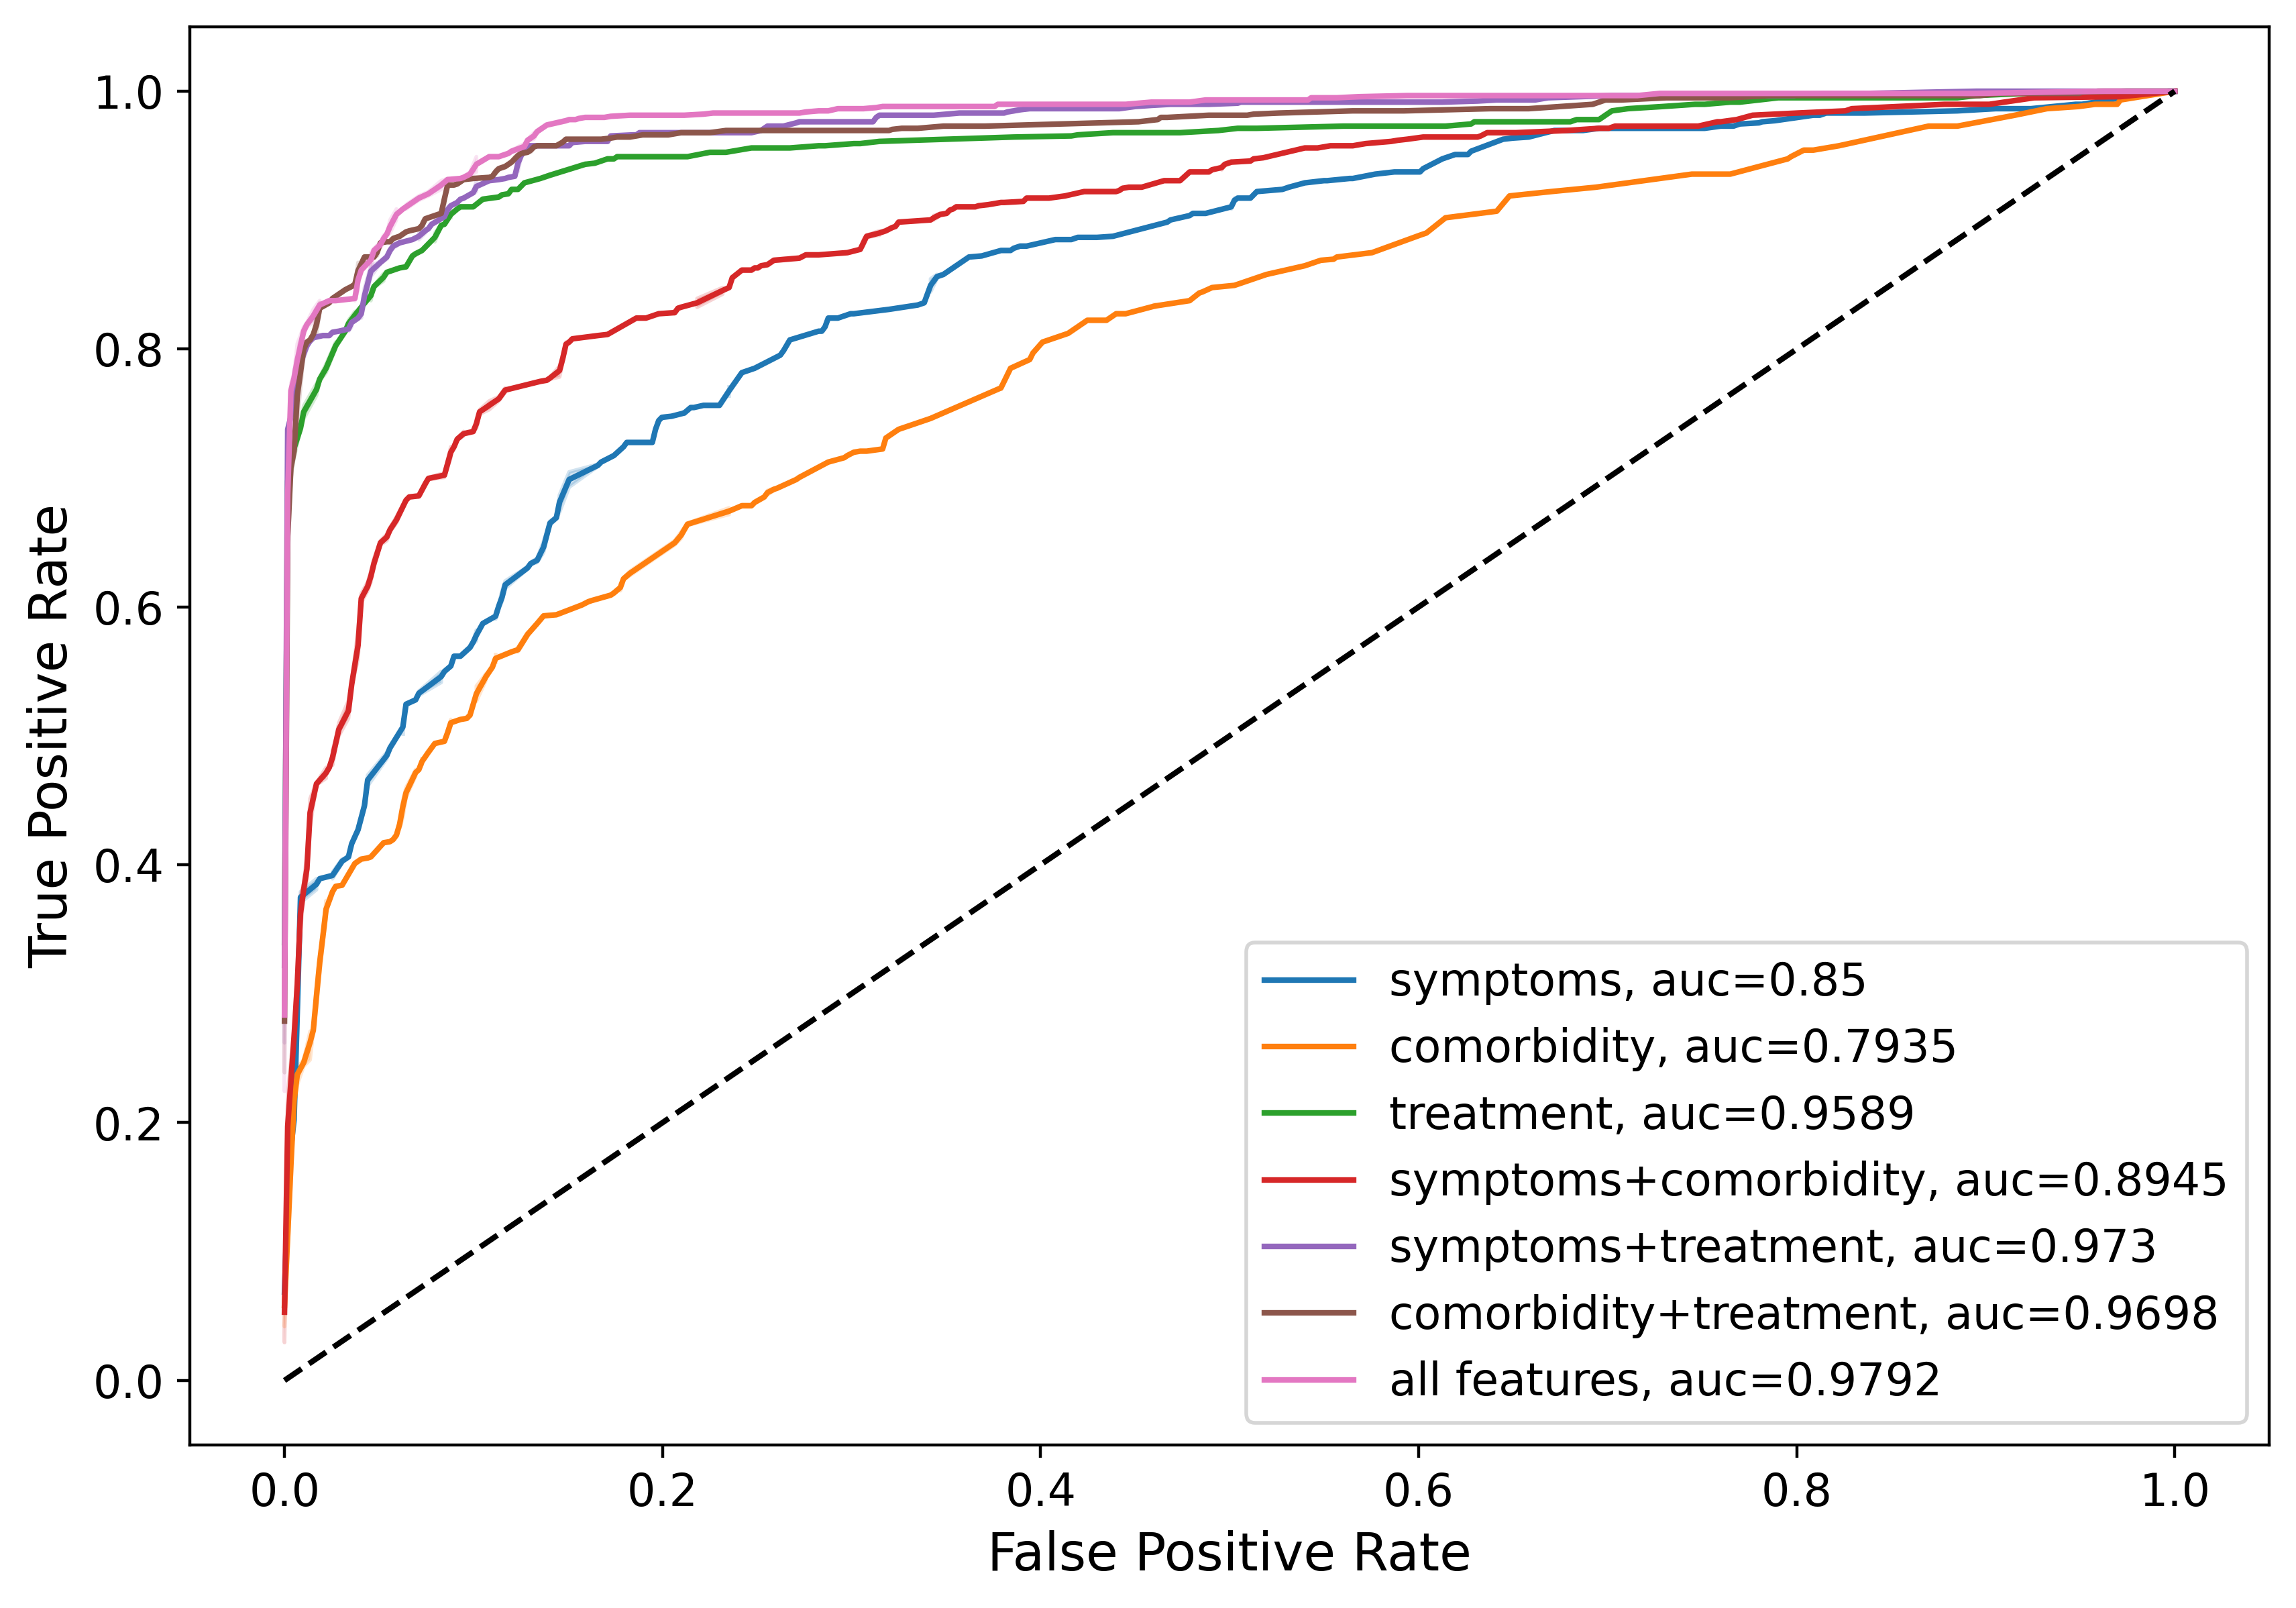

In [79]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=[10,7])
plt.rcParams['figure.dpi']=400

for i in range(len(legend)):
    fpr,tpr,auc=fpr_list[i],tpr_list[i],auc_list[i]
    sns.lineplot(fpr,tpr,label=legend[i]+f', auc={auc}')


plt.plot([0,1],'k--')
matplotlib.rcParams.update({'font.size': 12})
plt.legend()
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.savefig('figures/ablation-rocauc.jpg',dpi=400)
plt.show()

## ROC-AUC of top classifiers on all features

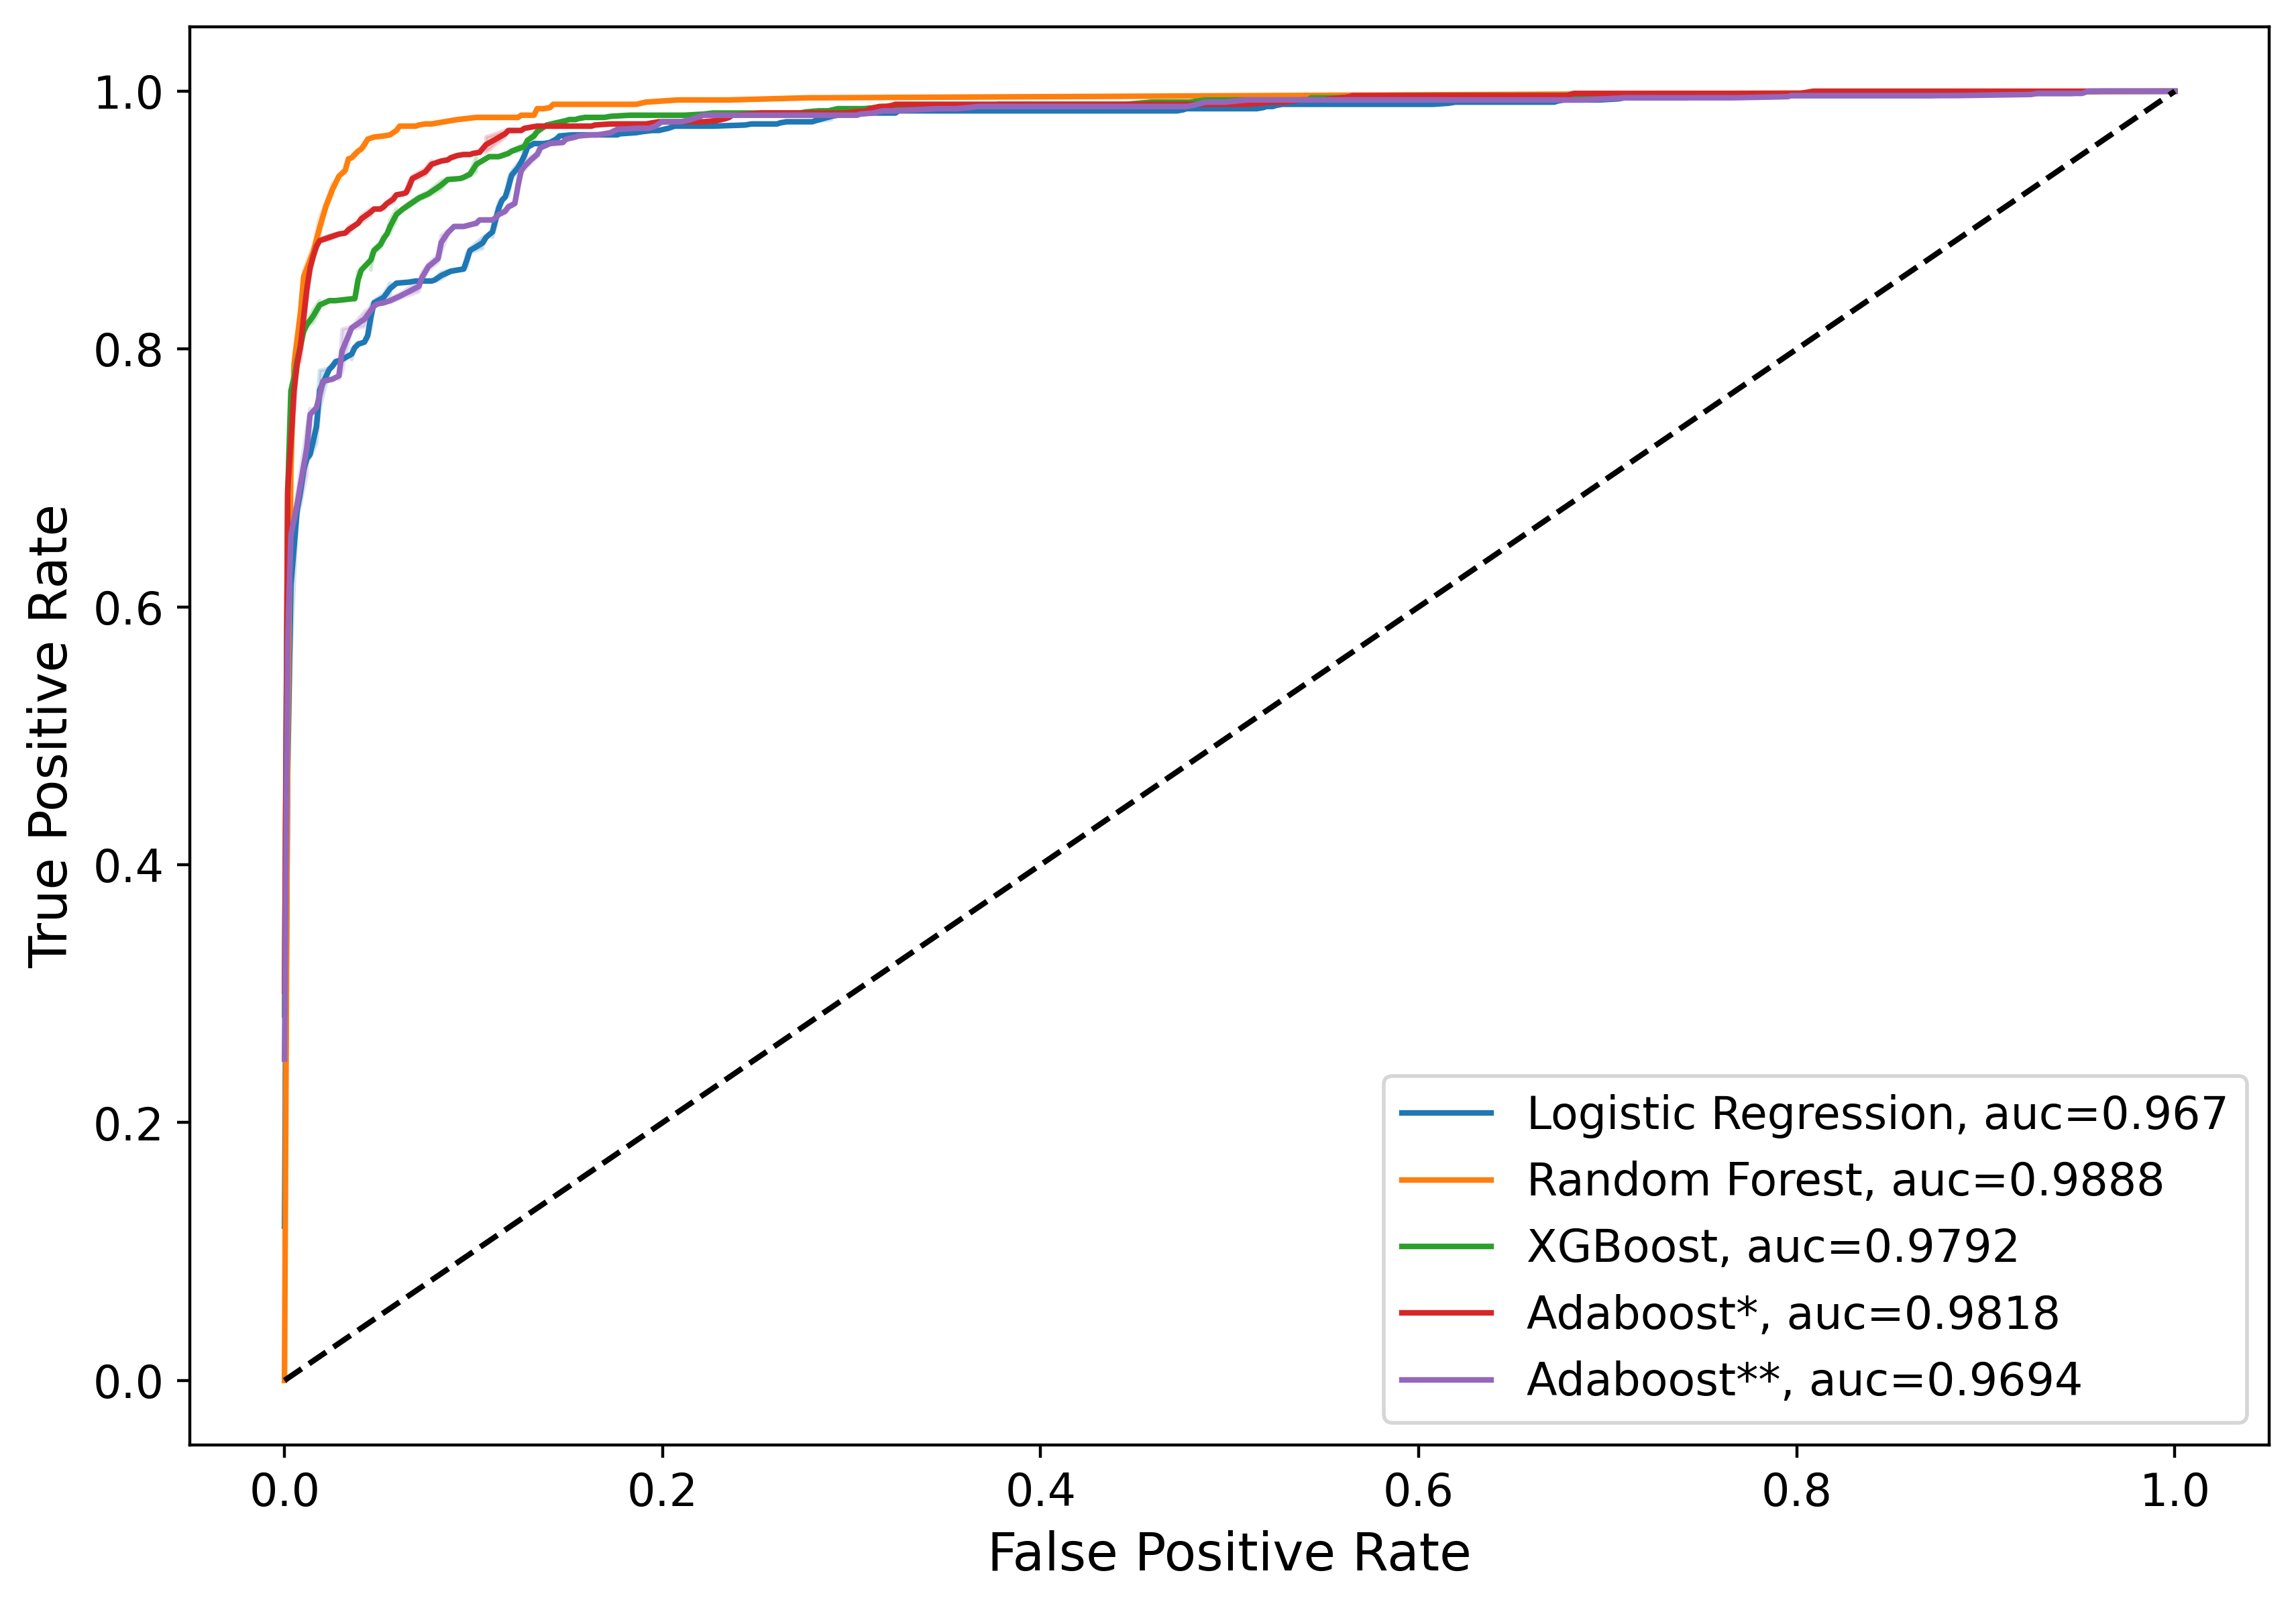

In [80]:
model_dic = {}
legend = ['Logistic Regression','Random Forest','XGBoost','Adaboost*','Adaboost**']
classifiers=[LogisticRegression(solver='newton-cg', class_weight={0: 5.5, 1:0.55},random_state=seed),
            RandomForestClassifier(n_estimators=200,random_state=seed),
            GradientBoostingClassifier(n_estimators=100,random_state=seed),
            AdaBoostClassifier(base_estimator=GradientBoostingClassifier(n_estimators=100,random_state=seed), n_estimators=5,random_state=seed),
            AdaBoostClassifier(n_estimators=54),  
            ]
smote = imblearn.over_sampling.SMOTE(sampling_strategy='minority',random_state=seed)
X_over, y_over = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, stratify=y_over,shuffle=True,random_state=seed)

fpr_list,tpr_list,auc_list=[],[],[]

for i in range(len(legend)):
    classifier = classifiers[i]
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)

plt.rcParams['figure.dpi']=400
plt.figure(figsize=[10,7])

for i in range(len(legend)):
    fpr,tpr,auc=fpr_list[i],tpr_list[i],auc_list[i]
    sns.lineplot(fpr,tpr,label=legend[i]+f', auc={auc}')

plt.plot([0,1],'k--')
matplotlib.rcParams.update({'font.size': 12})
plt.legend()
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.savefig('figures/top-classifiers-rocauc.jpg',dpi=400)
plt.show()



In [81]:
print(auc_list)

[0.967, 0.9888, 0.9792, 0.9818, 0.9694]


# Interpretability

## SHAP

In [82]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy='minority',random_state=seed)
X_over, y_over = smote.fit_resample(X, y)
X_over.rename(columns={'breadth':'breathlessness'},inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, stratify=y_over,shuffle=True,random_state=seed)
Counter(y_over)

Counter({1: 2955, 0: 2955})

In [83]:
gb_final = GradientBoostingClassifier(n_estimators=100,random_state=seed)
gb_final.fit(X_over, y_over)

GradientBoostingClassifier(random_state=0)

In [84]:
explainer = shap.TreeExplainer(gb_final)
shap_values=explainer.shap_values(X_over)

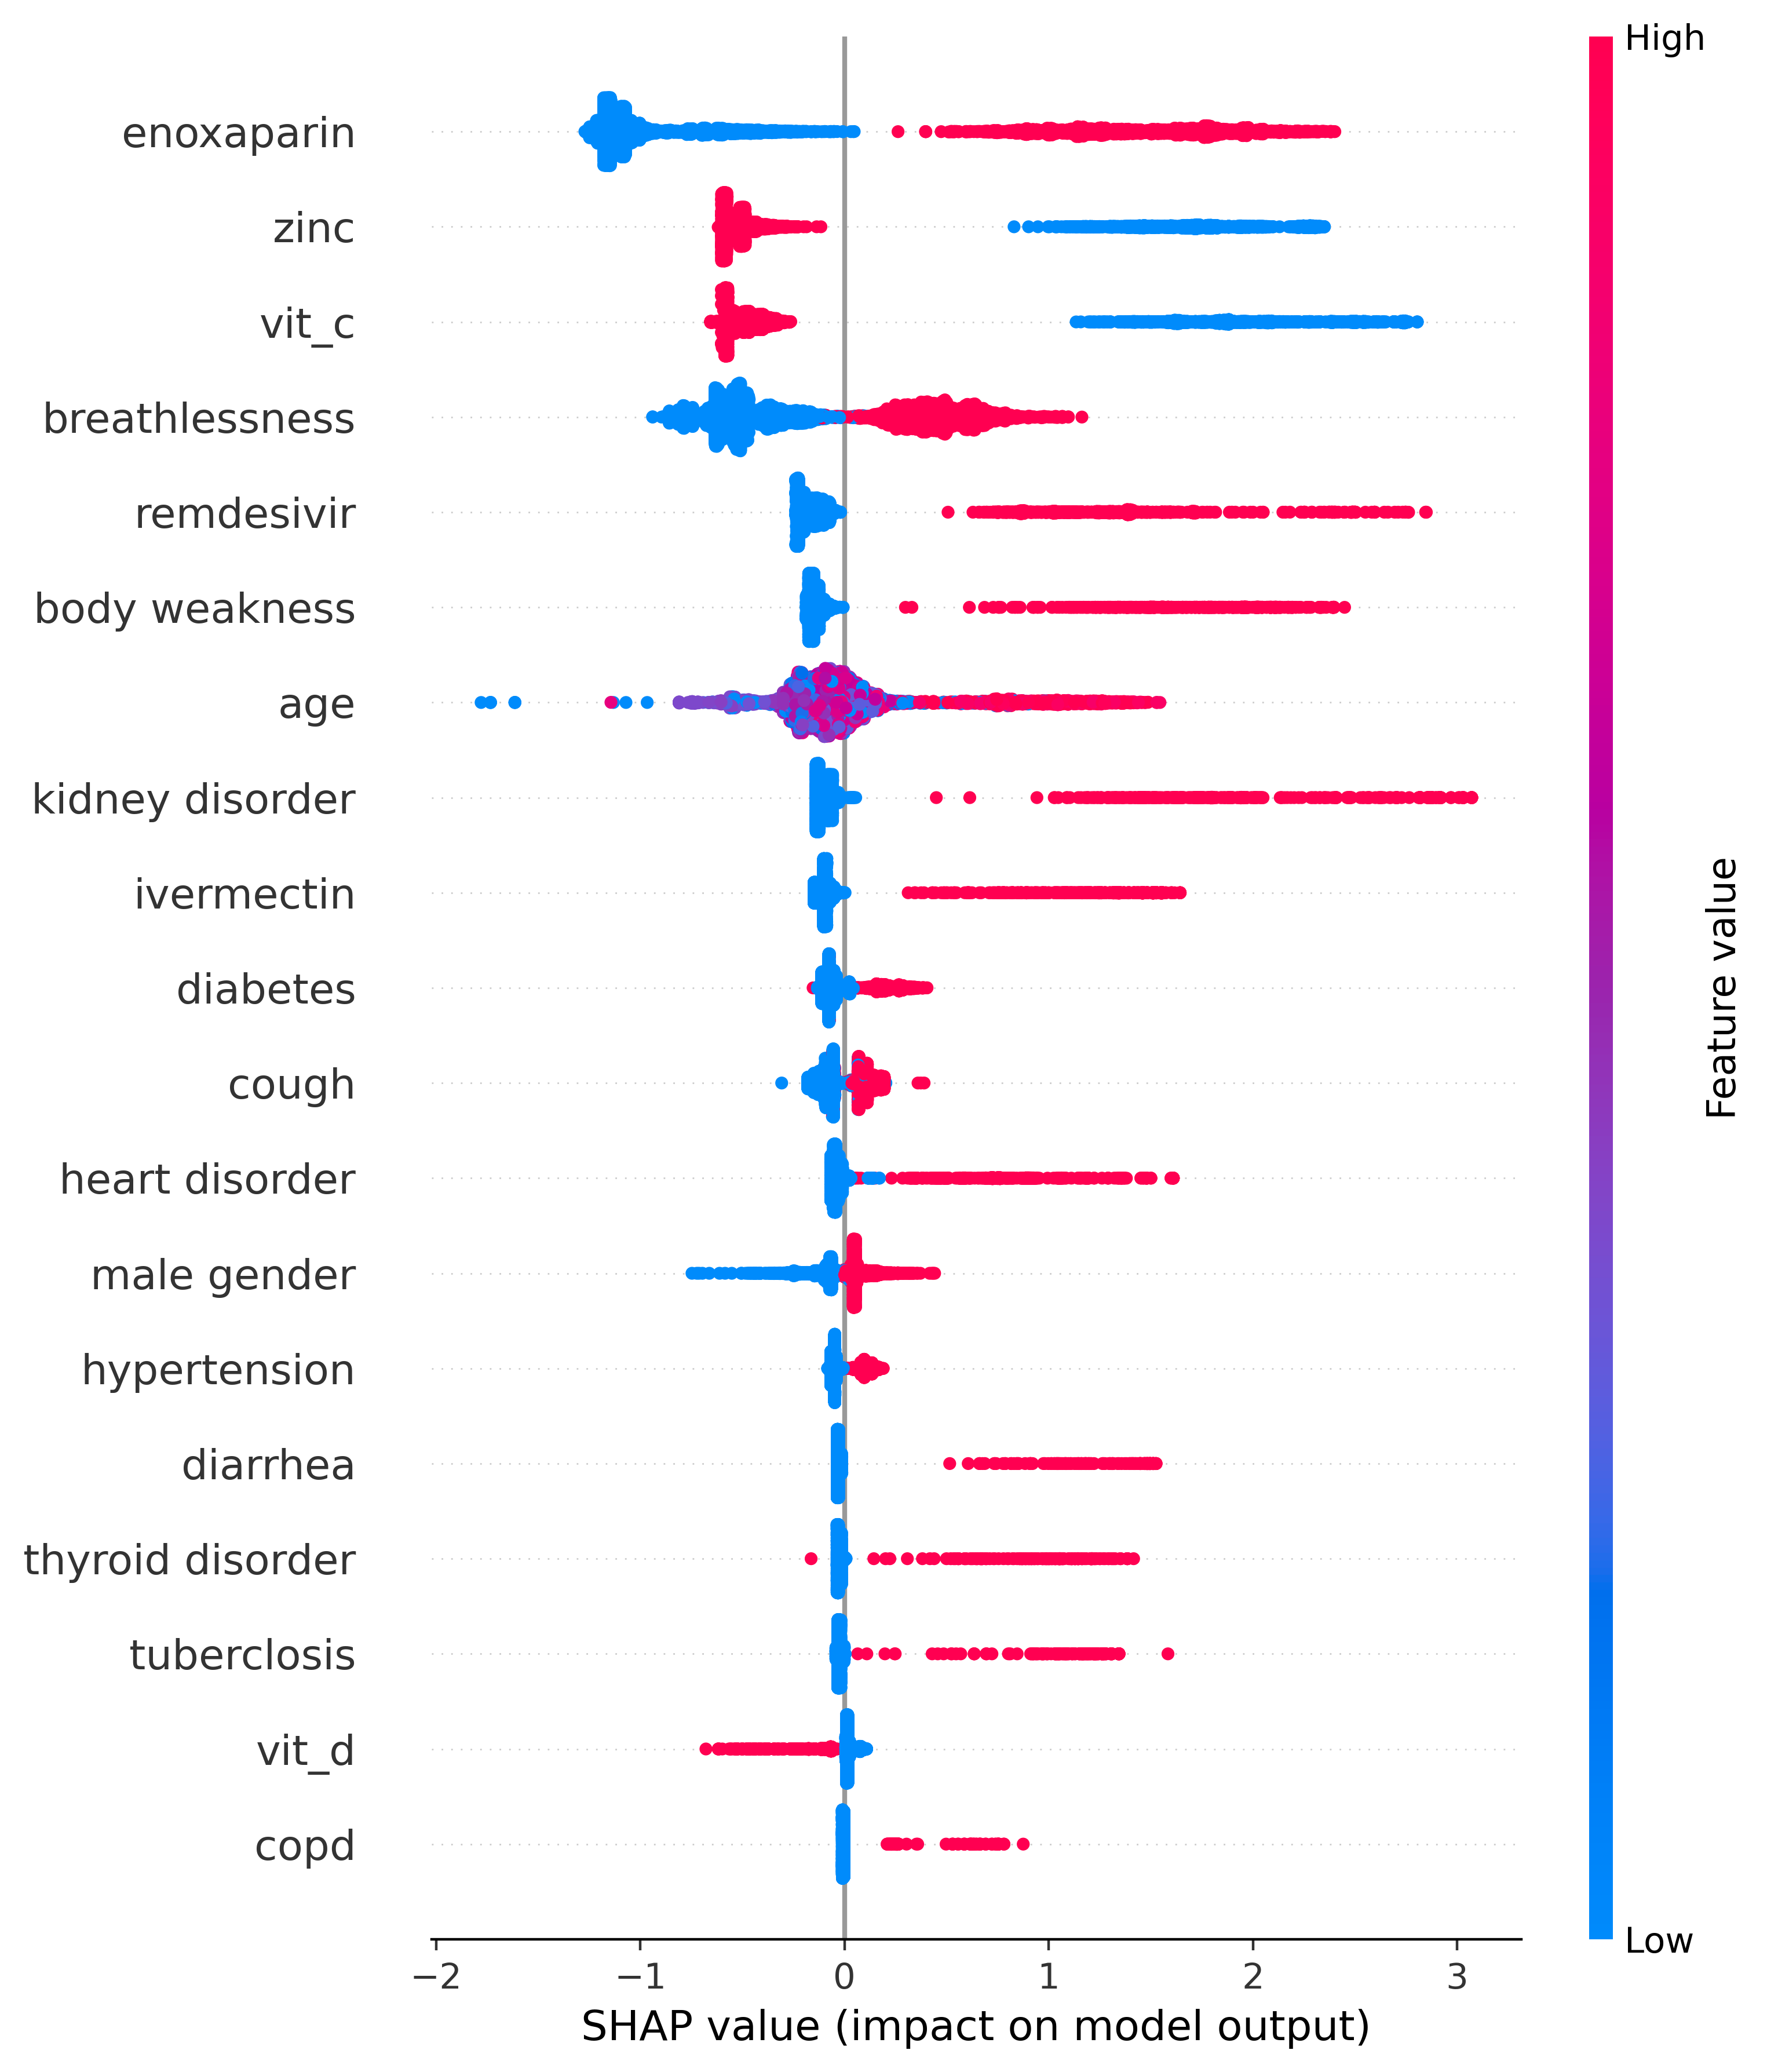

In [85]:
shap.summary_plot(shap_values,X_over,plot_type='dot',show=False)
plt.savefig('figures/shap-beeswarm.jpg',dpi=400)

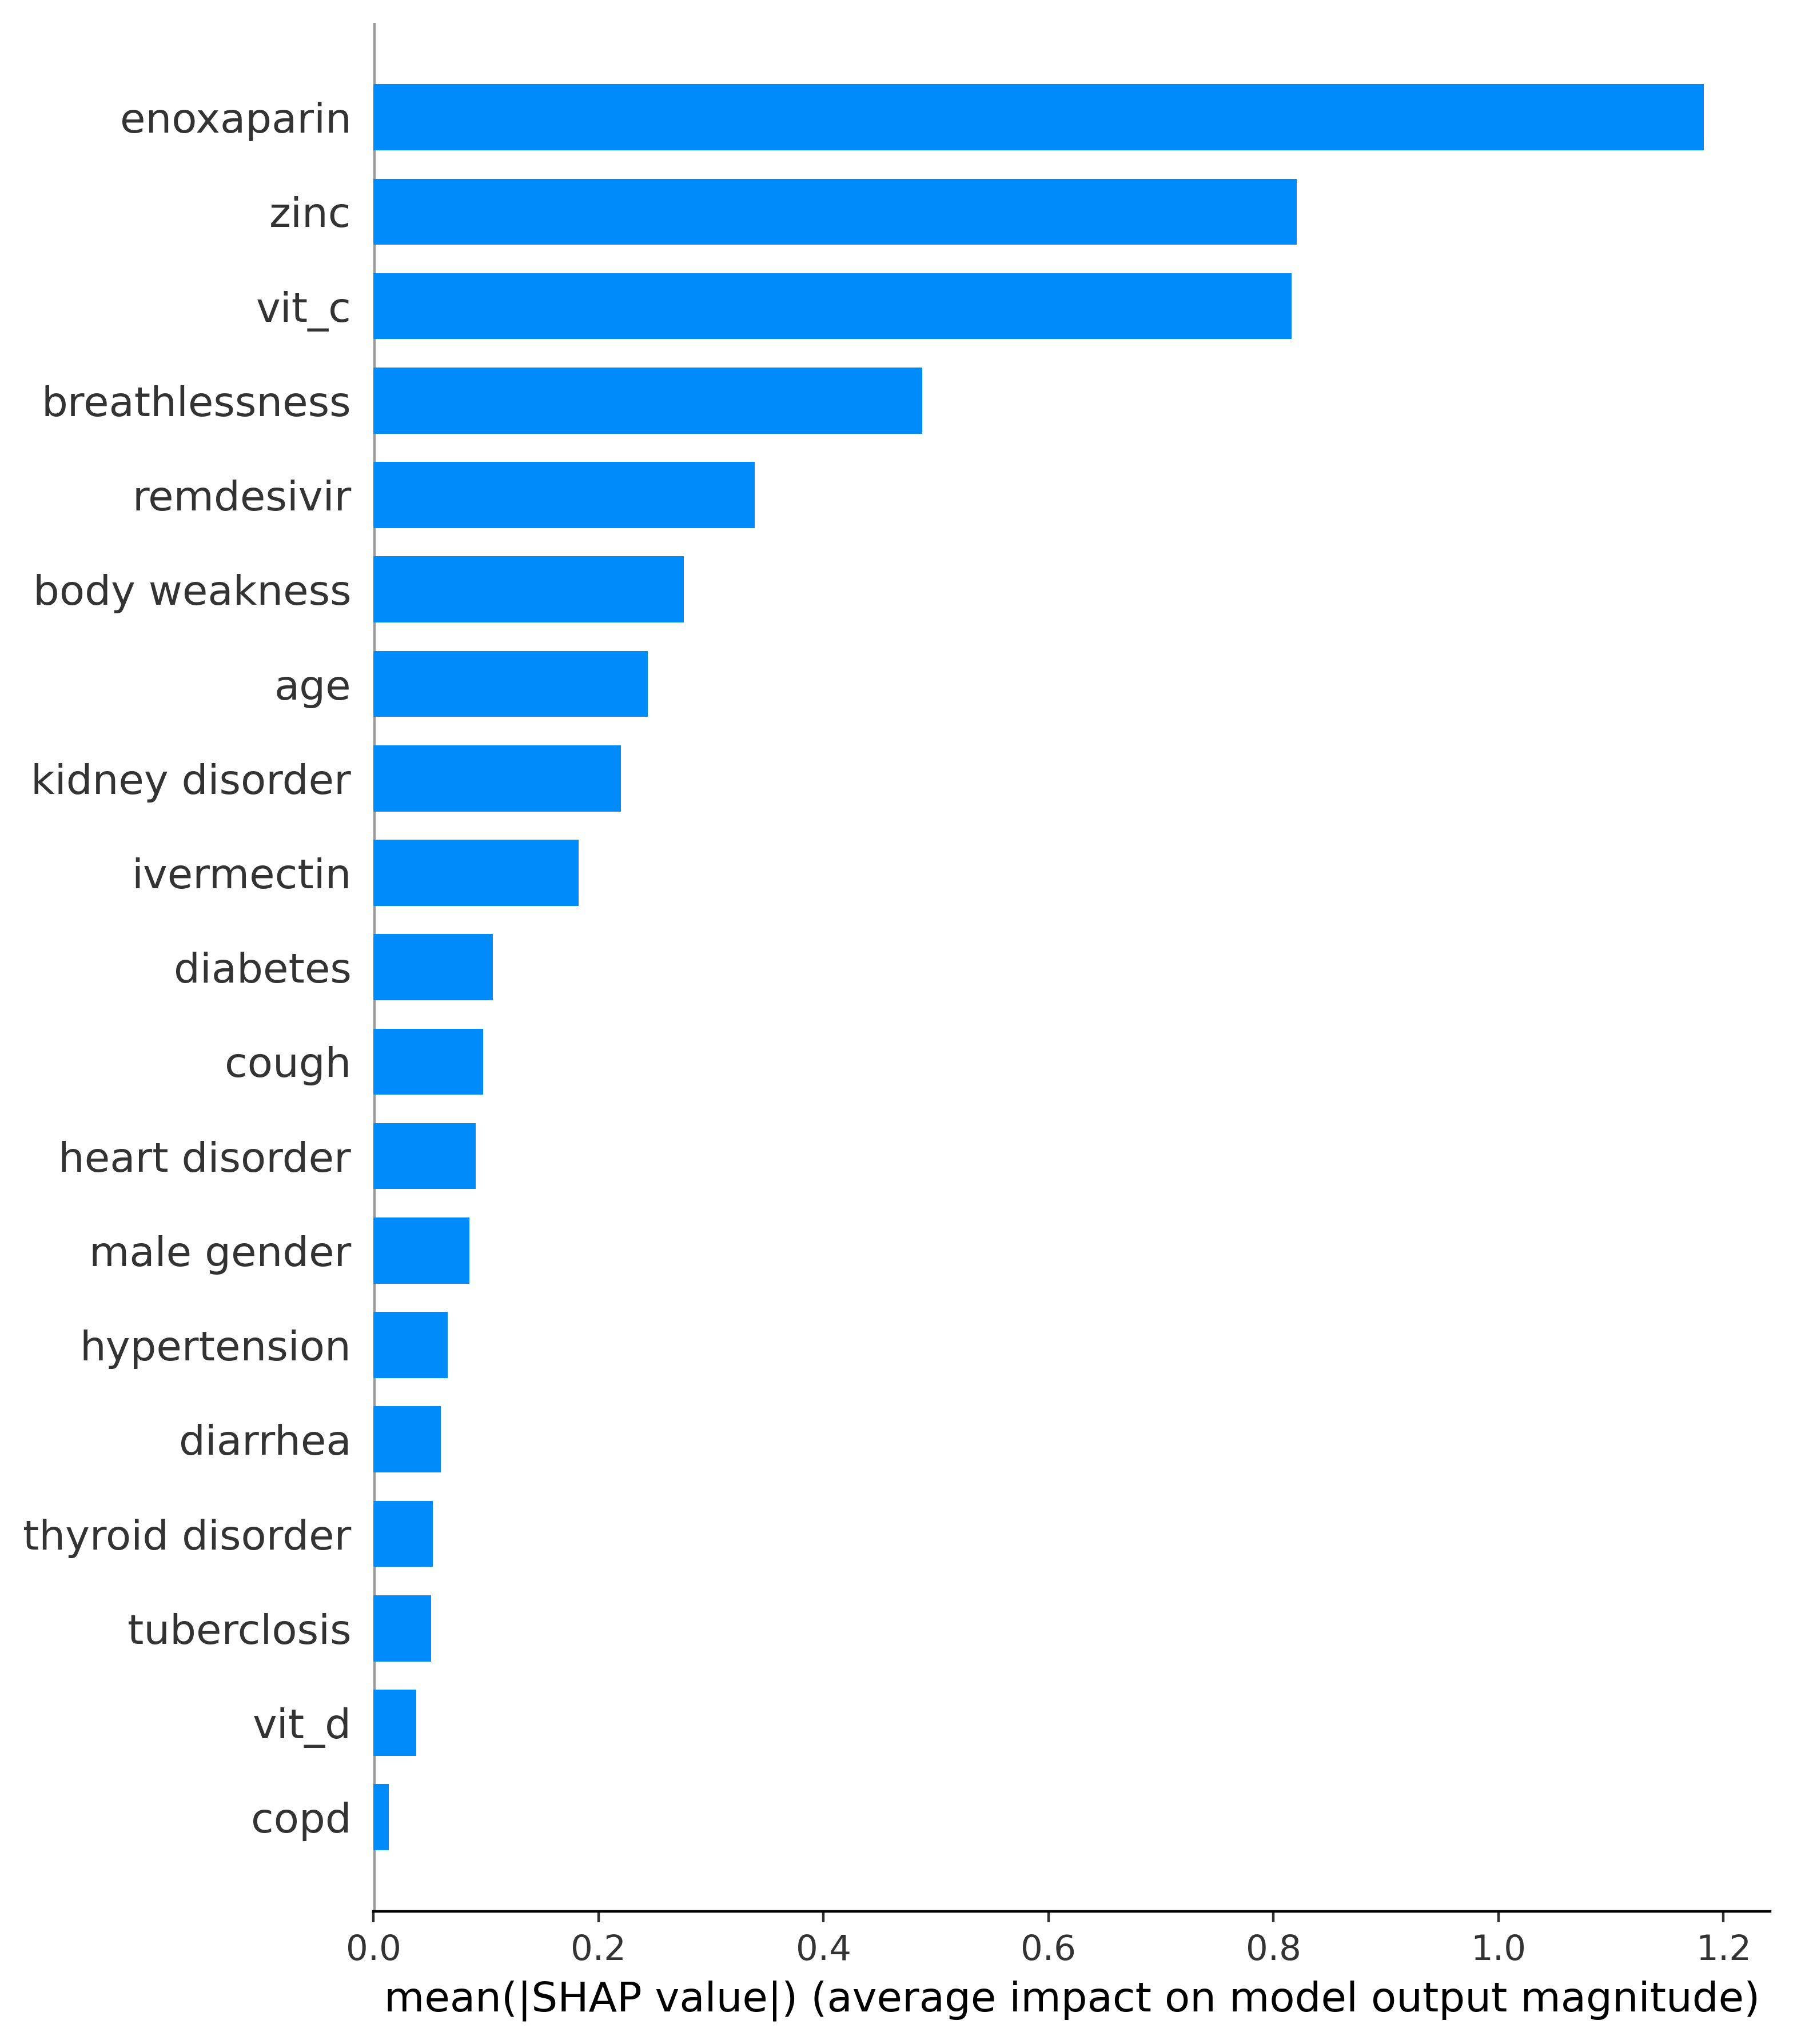

In [86]:
shap.summary_plot(shap_values,X_over,plot_type='bar',show=False)
plt.savefig('figures/shap-bar.jpg',dpi=400)

## LIME

In [87]:
import lime
from lime import lime_tabular

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,shuffle=True,random_state=seed)
smote = imblearn.over_sampling.SMOTE(sampling_strategy='minority',random_state=seed)
X_train,y_train = smote.fit_resample(X_train,y_train)
X_test,y_test = smote.fit_resample(X_test,y_test)

gb_final = GradientBoostingClassifier(n_estimators=100,random_state=seed)
gb_final.fit(X_train, y_train)


explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['discharged', 'death'],
    mode='classification',
    random_state=seed
)

In [88]:
eg = gb_final.predict_proba(X_test).argmax(axis=0)

In [89]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[eg[1]], 
    predict_fn=gb_final.predict_proba,
    num_features=X_test.shape[1]
)

exp.show_in_notebook()

In [90]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[eg[0]], 
    predict_fn=gb_final.predict_proba,
    num_features=X_test.shape[1]
)


exp.show_in_notebook()

In [91]:
#get lime explanation as 600 dpi jpeg


In [92]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[81],    
    predict_fn=gb_final.predict_proba,
    num_features=X_test.shape[1]
)

exp.show_in_notebook(show_table=True)